## Use 16kbp chunks for creating more training data 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster,distance  
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
from tqdm import tqdm

In [2]:
word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190612-1611-k10to10-100d-10c-4870Mbp-sliding-kPR.w2v')

In [3]:
FASTA="/data/genomes/dna2vec_train/"
ff = glob.glob(f"{FASTA}*.fasta")
X = {}
for file in tqdm(ff):
    for record in SeqIO.parse(file, "fasta"):
        seq=str(record.seq)
        X[record.description]=seq

100%|██████████| 4715/4715 [00:03<00:00, 1490.95it/s]


In [5]:
descr = X.keys()
fastas = pd.DataFrame(data=list(X.values()))
fastas["ID"] = [x.split()[0] for x in descr]
fastas["genus"] = [x.split()[1] for x in descr]
fastas["len"] = [len(x) for x in X.values()]
fastas.head()

,0,ID,genus,len
0,ATGGTAATATCGCTCCTTTGGATTGGGTTTCGTCACTTTTATCTTA...,NZ_CAPG01000111.1,Bacillus,22347
1,TTTTTATTTATTCAGCAGCCTTAAACGGTCAACCTATAGAAAAAAT...,NZ_LN886493.1,Planktothrix,1670
2,CCCCCCCCCGCTGGCACAGACCCCACATGATAAGACGAGTCTGATT...,NZ_LDJH01000056.1,Stenotrophomonas,1317
3,ATCAGGACAGCGCTGGCTGCCTACTCTCTTGCATCCAAGGCGAATA...,NZ_FQXZ01000009.1,Vibrio,586
4,GACCGTGGGGTGGGGTCGTGTCGGGGTGCCCCCGCAGCAAACTGCA...,NZ_JXDG01000067.1,Pseudomonas,72512


In [7]:
longer = fastas.loc[fastas["len"] > 16000,:];longer.shape

(2130, 4)

In [8]:
ksent_len = 16000
ksent = {}
for i in tqdm(range(longer.shape[0])):
    s = longer.iloc[i,0]
    vectors = []
    for hop in range((len(s) // ksent_len)):
        seq = "".join(s[hop:hop+ksent_len])
        t = ["".join(seq[i:i+10]) for i in range(len(seq)-10)]
        tokens = list(filter(lambda x: set(x) == {'A', 'C', 'G', 'T'}, t))
        vectors.append(np.mean(word_vectors[tokens], axis=0))
    ksent[longer.iloc[i,1]] = (longer.iloc[i,2], vectors)

100%|██████████| 2130/2130 [20:54<00:00,  2.17it/s]  


In [ ]:
sentences = pd.DataFrame(ksent.keys())
sentences['vectors'] = [ksent[x][1] for x in ksen.keys()]
sentences['genus'] = [ksent[x][0] for x in ksen.keys()]
sentences['n'] = [len(ksent[x][1]) for x in ksen.keys()]
sentences.sort_values(by="n", ascending=False,inplace=True)
sentences.reset_index(drop=True,inplace=True)
sentences.to_pickle("../data/ksen-sentences.pkl")

In [5]:
sentences = pd.read_pickle("../data/ksen-sentences.pkl")
sentences.head(10)

,0,vectors,genus,n
0,NZ_AJTN02000197.1,"[[-0.040759552, 0.13493565, 0.11740411, 0.0319...",Bacillus,518
1,NZ_FOWX01000006.1,"[[-0.03424186, 0.10903403, 0.15674573, -0.0431...",Pseudomonas,509
2,NZ_LGUX01000047.1,"[[-0.02221683, 0.16862509, 0.13689668, -0.0279...",Streptomyces,416
3,NZ_LAQO01000097.1,"[[-0.032138012, 0.13535376, 0.11554951, -0.080...",Paenibacillus,408
4,NZ_JNNU01000024.1,"[[-0.09971707, 0.14343369, 0.073053084, -0.051...",Rhizobium,391
5,NZ_JDSA01000159.1,"[[-0.029859722, 0.09358531, 0.117933616, -0.06...",Clostridium,375
6,NZ_FULE01000075.1,"[[-0.029456131, 0.1513094, 0.16170317, -0.0625...",Vibrio,374
7,NZ_FWWS01000035.1,"[[-0.029456131, 0.1513094, 0.16170317, -0.0625...",Corynebacterium,374
8,NZ_JDSA01000158.1,"[[0.012553351, 0.058161315, 0.11874426, -0.032...",Clostridium,370
9,NZ_JNNU01000023.1,"[[-0.07605679, 0.1315616, 0.099155806, -0.0717...",Rhizobium,345


## Reduce dimensions

In [ ]:
import sys, os
sys.path.append(".")
from KlsAutoencoder import *
e = Encoder("../data/models/encoder-3d",[100,50,3]);e

## Visualize  longest sequences

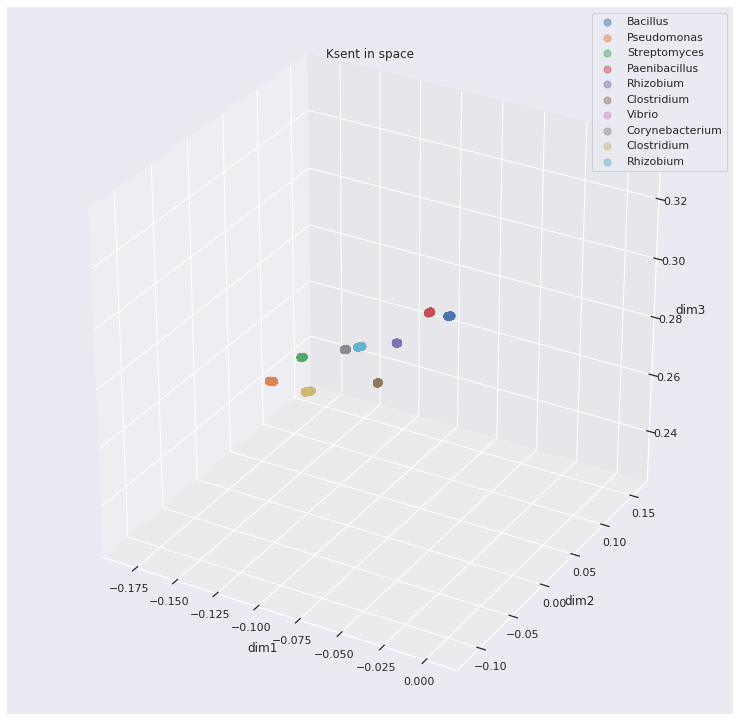

In [13]:
longest = sentences.iloc[:10,:]
data = [(e.transform(x["vectors"]), x["genus"]) for _, x in longest.iterrows()]

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111,projection="3d")
for s, label in data:
    ax.scatter(s[:,0],s[:,1],s[:,2], marker="o",s=50, alpha=0.5, label = label)
ax.set_xlabel('dim1')
ax.set_ylabel('dim2')
ax.set_zlabel('dim3')
ax.set_title("Ksent in space")
plt.legend()
plt.show()

## Observations

- genome has own position in a latent space
- all Ksent (k-sentences of lenght 16K) of a genome cluster together
- it seems that any Ksent of a genome carries similar information and can serve as an estimate for entire sequence in the latent space

IDEA:
- sample ksent from sequences and create sentence vectors
- make it into a Word2Vec instance
- use model.most_similar(positive=['woman', 'king'], negative=['man']) to find related areas of other genomes